In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from bokeh.models import LogColorMapper
# from bokeh.palettes import Viridis6 as palette
import pandas as pd
from bokeh.models import ColumnDataSource
import shapely
from bokeh.plotting import save, figure
import numpy as np
from bokeh.palettes import RdYlGn6 as palette
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def transform_CS92_to_lat_long(x_in, y_in):
    inProj = Proj(init='epsg:2180')
    outProj = Proj(init='epsg:4326')
    y_out,x_out = transform(Proj(init='epsg:2180'), Proj(init='epsg:4326'), x_in, y_in)
    return x_out,y_out

In [2]:
borders = gpd.read_file("GminyLatLong.shp")
wszystkie_gminy = pd.read_csv("GminyKarpatyWCalosciProcentParkuN.csv")
# dochod_wlasny = pd.read_csv("dochod_wlasny_2019.csv")
dochod_wlasny = pd.read_csv("dochod-wlasny.csv")
# kanalizacja = pd.read_csv("kanalizacja.csv")

dochod_wlasny = dochod_wlasny[['Kod','2019']]
dochod_wlasny["Kod"] = dochod_wlasny["Kod"].apply(lambda x: str(x))
park_tresh = 5
wszystkie_gminy["is_park"] = wszystkie_gminy["ProcentGminyObjetyParkiemN"].apply(lambda x: True if x >= park_tresh else False)
wszystkie_gminy.astype({'Kod': 'str'}).dtypes
codes = [str(i) for i in wszystkie_gminy.Kod.values]
borders = borders[borders.KodGminy.isin(codes)]

In [3]:

borders['ok']  = borders['geometry'].apply(lambda x: True if type(x.boundary) == shapely.geometry.linestring.LineString else False)
borders['type']  = borders['geometry'].apply(lambda x: str(type(x.boundary)))
wszystkie_gminy["Kod"] = wszystkie_gminy["Kod"].apply(lambda x: str(x))
gminy = wszystkie_gminy["Kod"].values
# borders = borders[borders['KodGminy'].isin(gminy)]
multi_poly_borders = borders[~borders["ok"]]
borders = borders[borders["ok"]]

n: 0


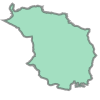

---
n: 1


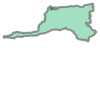

/tmp/ipykernel_641977/448244625.py:15: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for i in range(len(p)):
/tmp/ipykernel_641977/448244625.py:16: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  display(p[i])


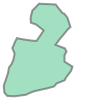

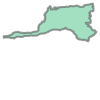

---
n: 2


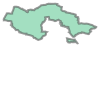

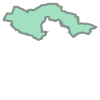

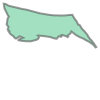

---
n: 3


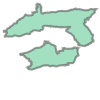

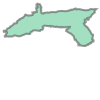

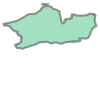

---
n: 4


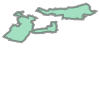

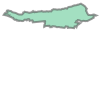

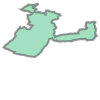

---
n: 5


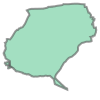

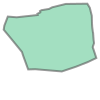

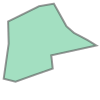

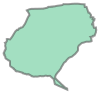

---
n: 6


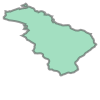

---


In [4]:
multipolygon = multi_poly_borders['geometry']

polygons = list(multipolygon)
polys = []
for polygon in multipolygon:
    polys.append(polygon)
n = 0    
for p in polys:
    print("n:",n)
    if type(p) == shapely.geometry.polygon.Polygon:
        display(p)

    elif type(p) == shapely.geometry.multipolygon.MultiPolygon:
        display(p)
        for i in range(len(p)):
            display(p[i])
    print("---")
    n+=1


In [5]:
pn = gpd.read_file("pn/pn.shp")#"pn/pn.shp"

carpathian_national_parks = ["Babiogórski Park Narodowy","Bieszczadzki Park Narodowy","Gorczański Park Narodowy","Magurski Park Narodowy","Pieniński Park Narodowy","Tatrzański Park Narodowy"]
pn = pn[pn["Nazwa"].isin(carpathian_national_parks)]
pn = pn.to_crs("EPSG:4326")


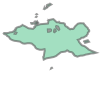

/tmp/ipykernel_641977/409263844.py:15: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for i in p:


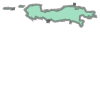

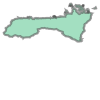

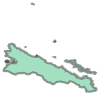

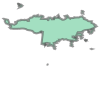

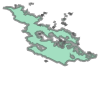

In [6]:
 
pn_polys = []
pn_names = []

for polygon,name in zip(pn['geometry'],pn["Nazwa"]):
    pn_polys.append(polygon)
    pn_names.append(name)
pn_shapes = []
pn_names_shapes = []
for p,n in zip(pn_polys,pn_names):
    display(p)
    if type(p) == shapely.geometry.polygon.Polygon:
        pn_shapes.append(p)
        pn_names_shapes.append(n)
    elif type(p) == shapely.geometry.multipolygon.MultiPolygon:
        for i in p:
            pn_shapes.append(i)
            pn_names_shapes.append(n)



In [7]:
multi2poly = []
for p in polys:
    if not hasattr(p, "__getitem__"):
        multi2poly.append(p)
    else:
        multi2poly.append(p[0])
        multi2poly.append(p[1])
multi2poly_codes = ['1207032', 
                    '1207052', '1207052',
                    '1210022', '1210022', 
                    '1215052', '1215052',
                    '1805042', '1805042', 
                    '2402062', '2402062',
                    '2403042']

/tmp/ipykernel_641977/2035695462.py:6: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multi2poly.append(p[0])
/tmp/ipykernel_641977/2035695462.py:7: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  multi2poly.append(p[1])


In [8]:
borders = borders[["KodGminy","geometry"]].append( gpd.GeoDataFrame(zip(multi2poly_codes,multi2poly), columns=["KodGminy","geometry"]) )
borders = borders.merge(wszystkie_gminy[wszystkie_gminy.Kod.isin(gminy)], left_on='KodGminy', right_on='Kod')
borders = borders.merge(dochod_wlasny, left_on='Kod', right_on='Kod')

/tmp/ipykernel_641977/1363838925.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  borders = borders[["KodGminy","geometry"]].append( gpd.GeoDataFrame(zip(multi2poly_codes,multi2poly), columns=["KodGminy","geometry"]) )


In [16]:
palette = tuple(reversed(palette))

names = borders.Nazwa.values
income = borders["2019"].values
p_park = [str(np.round(b,1)) for b in borders["ProcentGminyObjetyParkiemN"].values]
color_mapper = LogColorMapper(palette=palette)

x, y= [], []
[(x.append(list(polygon.exterior.coords.xy[0])), 
  y.append(list(polygon.exterior.coords.xy[1]))) for polygon in borders['geometry'] 

]
pn_x, pn_y= [], []
[(pn_x.append(list(polygon.exterior.coords.xy[0])), 
  pn_y.append(list(polygon.exterior.coords.xy[1]))) for polygon in pn_shapes 

]
pn_data=ColumnDataSource(dict(
    x=pn_x,
    y=pn_y,
    name=pn_names_shapes,

))
data=ColumnDataSource(dict(
    x=x,
    y=y,
    name=names,
    income=income,
    p_park=p_park
))

TOOLS = "pan, wheel_zoom, reset, save"

p = figure(
    title="Dochód na osobę dla gmin regionu Karpat.", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
#     tooltips=[
#         ("Nazwa Gminy", "@name"), ("Dochód na osobę", "@income{int} zł"), ("Park", "@p_park % powierzchni"),
#     ],
    plot_width=2000, plot_height=1000
)
p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

In [17]:
p_muni = p.patches('x', 'y', source=data,
          fill_color={'field': 'income', 'transform': color_mapper},
          fill_alpha=1, line_color="white", line_width=0.5
         )
p_parks = p.patches('x', 'y', source=pn_data,
          fill_color="green",
          fill_alpha=0.5, line_color="black", line_width=0.5,
          hatch_pattern='right_diagonal_line'
         
         )

p.add_tools(HoverTool(renderers=[p_muni], tooltips=[
        ("Nazwa Gminy", "@name"), ("Dochód na osobę", "@income{int} zł"), ("Park", "@p_park % powierzchni"),],))
p.add_tools(HoverTool(renderers=[p_parks], tooltips=[("", "@name")]))
outfp = "kartogram.html"
# save(p, outfp)

'/home/kwaks/gejopandas/kartogram/kartogram.html'